In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA.data import loading_tools
from JPAS_DA.data import wrapper_data_loaders

import numpy as np

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

In [2]:
# === Paths and Dataset Definitions ===
data_paths = {
    "root_path": "/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/DATA/noise_jpas_v1/Train-Validate-Test",
    "load_JPAS_data": [
        {"name": "all", "npy": "JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy", "csv": "JPAS_DATA_PROPERTIES.csv", "sample_percentage": 1.0}
    ],
    "load_DESI_data": [
        {"name": "train", "npy": "mock_3_train.npy", "csv": "props_training.csv", "sample_percentage": 0.1},
        {"name": "val", "npy": "mock_3_validate.npy", "csv": "props_validate.csv", "sample_percentage": 1.0},
        {"name": "test", "npy": "mock_3_test.npy", "csv": "props_test.csv", "sample_percentage": 1.0}
    ],
    "random_seed_load": 42
}

# === Cleaning Options ===
dict_clean_data_options = {
    "apply_masks"         : ["unreliable", "magic_numbers", "negative_errors", "nan_values", "apply_additional_filters"],
    "mask_indices"        : [0, -2],
    "magic_numbers"       : [-99, 99],
    "i_band_sn_threshold" : 150.,
    "z_lim_QSO_cut"       : 2.2
}

# === Splitting Options ===
dict_split_data_options = {
    "train_ratio_both"            : 0.8,
    "val_ratio_both"              : 0.1,
    "test_ratio_both"             : 0.1,
    "random_seed_split_both"      : 42,

    "train_ratio_only_DESI"       : 0.8,
    "val_ratio_only_DESI"         : 0.1,
    "test_ratio_only_DESI"        : 0.1,
    "random_seed_split_only_DESI" : 42
}

# === Features and Labels ===
features_labels_options = {
    "keys_xx": ['OBS', 'ERR', 'MORPHTYPE_int'],
    "keys_yy": ['SPECTYPE_int', 'TARGETID'],
    "normalize": True
}

In [3]:
DATA = loading_tools.load_dsets(
    root_path=data_paths["root_path"],
    datasets_jpas=data_paths["load_JPAS_data"],
    datasets_desi=data_paths["load_DESI_data"],
    random_seed=data_paths["random_seed_load"]
)

2025-05-16 12:51:54,453 - INFO - 📥 Starting full dataset loading with `load_dsets()`
2025-05-16 12:51:54,454 - INFO - ├ Loading JPAS datasets...
2025-05-16 12:51:54,454 - INFO - ├─── 📥 Starting JPAS dataset loading...
2025-05-16 12:51:54,454 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-05-16 12:51:54,498 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-05-16 12:51:54,510 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-05-16 12:51:54,510 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-05-16 12:51:54,511 - INFO - ├ Loading DESI datasets (splitted)...
2025-05-16 12:51:54,511 - INFO - ├─── 📥 Starting DESI dataset loading...
2025-05-16 12:51:54,511 - INFO - |    ├─── 🔹 Dataset: train
2025-05-16 12:51:55,445 - INFO - |    |    ✔ CSV loaded ((1087882, 18)), Size: 445.74 MB
2025-05-16 12:51:55,446 - INFO - |    |    ✔ NPY loaded ((1087882, 57, 3)), Size: 1488.22 MB
2025-05-16 12:51:55,449 - I

In [4]:
dset_loaders = wrapper_data_loaders.wrapper_data_loaders(**data_paths, **dict_clean_data_options, **dict_split_data_options, **features_labels_options)

2025-05-16 12:51:56,323 - INFO - 📦 Starting full data preparation pipeline...
2025-05-16 12:51:56,324 - INFO - 

1️⃣: Loading datasets from disk...
2025-05-16 12:51:56,324 - INFO - 📥 Starting full dataset loading with `load_dsets()`
2025-05-16 12:51:56,324 - INFO - ├ Loading JPAS datasets...
2025-05-16 12:51:56,324 - INFO - ├─── 📥 Starting JPAS dataset loading...
2025-05-16 12:51:56,324 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-05-16 12:51:56,365 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-05-16 12:51:56,375 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-05-16 12:51:56,376 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-05-16 12:51:56,376 - INFO - ├ Loading DESI datasets (splitted)...
2025-05-16 12:51:56,376 - INFO - ├─── 📥 Starting DESI dataset loading...
2025-05-16 12:51:56,377 - INFO - |    ├─── 🔹 Dataset: train
2025-05-16 12:51:57,300 - INFO - |    |    ✔ CSV loaded ((108

In [5]:
key_survey = "JPAS_matched"
key_dset = "train"
NN = 2

unique_spectype_labels = dset_loaders[key_survey][key_dset].class_labels
sampled_TARGETIDs = []
for ii, label in enumerate(unique_spectype_labels):
    tmp_idxs = np.where(dset_loaders[key_survey][key_dset].yy["SPECTYPE_int"] == label)[0]
    tmp_TARGETIDs = dset_loaders[key_survey][key_dset].yy["TARGETID"][tmp_idxs]
    tmp_SPECTYPE_ints = dset_loaders[key_survey][key_dset].yy["SPECTYPE_int"][tmp_idxs]

    tmp_idxs = np.random.choice(len(tmp_TARGETIDs), NN, replace=False)
    sampled_TARGETIDs.append(tmp_TARGETIDs[tmp_idxs])
sampled_TARGETIDs = np.array(sampled_TARGETIDs)

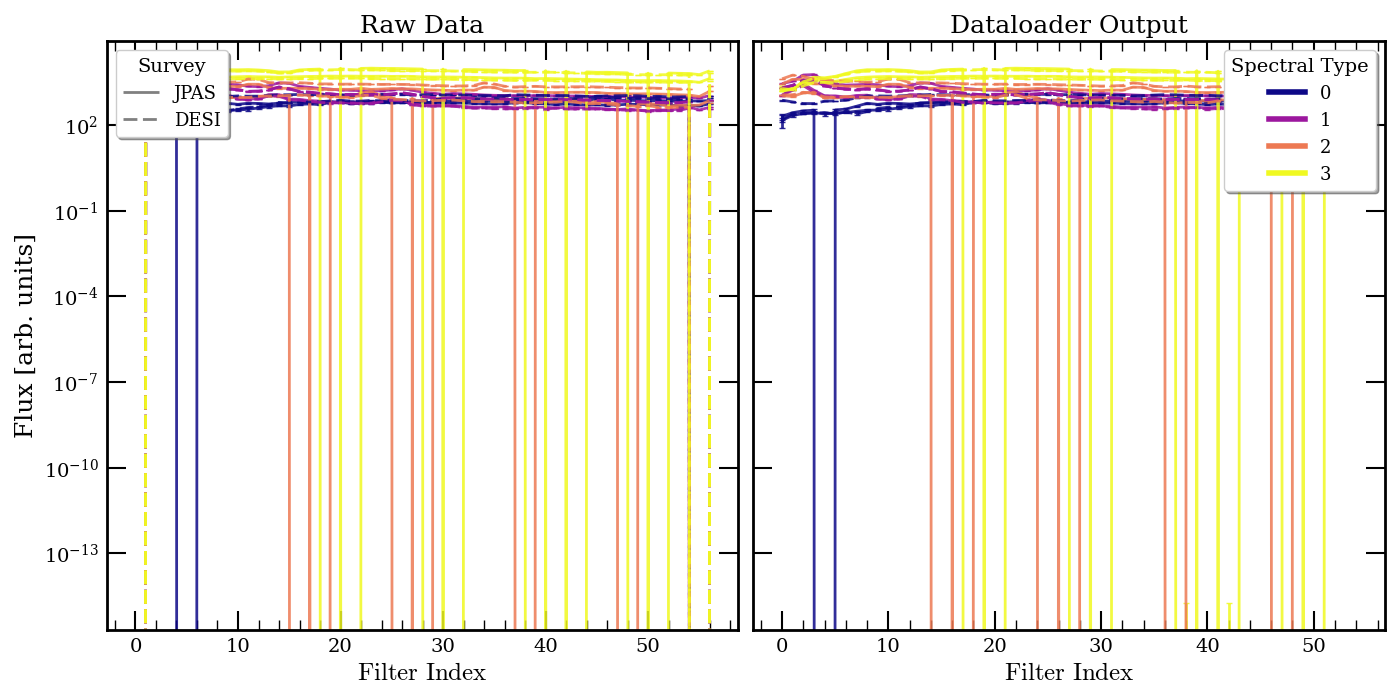

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

axs[0].set_title("Raw Data", fontsize=18)
axs[1].set_title("Dataloader Output", fontsize=18)

for ax in axs:
    ax.set_xlabel(r'$\mathrm{Filter~Index}$', fontsize=18)
axs[0].set_ylabel(r'Flux [arb. units]', fontsize=18)

colors = plotting_utils.get_N_colors(len(unique_spectype_labels), colormap=plt.cm.plasma)
linestyles = plotting_utils.get_N_linestyles(2)  # "JPAS", "DESI"

for ii, key_survey in enumerate(["JPAS_matched", "DESI_combined"]):
    for jj, spectype in enumerate(unique_spectype_labels):
        for kk in range(NN):
            tmp_TARGETID = sampled_TARGETIDs[jj][kk]

            # --- Plot RAW data (subplot 0) ---
            tmp_key_raw = "JPAS" if "JPAS" in key_survey else "DESI"
            tmp_idxs = np.where(DATA[tmp_key_raw]['all_pd']["TARGETID"] == tmp_TARGETID)[0]

            for tmp_idx in tmp_idxs:
                if tmp_key_raw == "JPAS":
                    tmp_obs = DATA["JPAS"]['all_observations'][tmp_idx]
                    tmp_errors = DATA["JPAS"]['all_errors'][tmp_idx]
                else:
                    tmp_obs = DATA["DESI"]['all_np'][tmp_idx][:, 1]
                    tmp_errors = DATA["DESI"]['all_np'][tmp_idx][:, 2]

                neg_errors = tmp_errors[tmp_errors < 0]
                if len(neg_errors) > 0:
                    print("TARGETID", tmp_TARGETID, "-- Err value < 0:", neg_errors.max())
                tmp_errors = np.clip(tmp_errors, a_min=0, a_max=None)

                axs[0].errorbar(
                    np.arange(len(tmp_obs)), tmp_obs, yerr=tmp_errors,
                    capsize=2, lw=2., ls=linestyles[ii],
                    color=colors[jj], ecolor=colors[jj], alpha=0.85
                )

            # --- Plot DataLoader-processed data (subplot 1) ---
            tmp_idxs = np.where(dset_loaders[key_survey][key_dset].yy["TARGETID"] == tmp_TARGETID)[0]
            for tmp_idx in tmp_idxs:
                tmp_obs = dset_loaders[key_survey][key_dset].xx["OBS"][tmp_idx]
                tmp_errors = dset_loaders[key_survey][key_dset].xx["ERR"][tmp_idx]

                # Unnormalize if necessary
                tmp_obs = tmp_obs * dset_loaders[key_survey][key_dset].stds[0] + dset_loaders[key_survey][key_dset].means[0]
                tmp_errors = tmp_errors * dset_loaders[key_survey][key_dset].stds[1] + dset_loaders[key_survey][key_dset].means[1]

                neg_errors = tmp_errors[tmp_errors < 0]
                if len(neg_errors) > 0:
                    print("TARGETID", tmp_TARGETID, "-- Err value < 0:", neg_errors.max())
                tmp_errors = np.clip(tmp_errors, a_min=0, a_max=None)

                axs[1].errorbar(
                    np.arange(len(tmp_obs)), tmp_obs, yerr=tmp_errors,
                    capsize=2, lw=2., ls=linestyles[ii],
                    color=colors[jj], ecolor=colors[jj], alpha=0.85
                )

# Format plots
for ax in axs:
    ax.axhline(0, ls='--', lw=0.7, color='black', alpha=0.4)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_yscale("log")

# Legends
survey_handles = [
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[0], lw=2, label="JPAS"),
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[1], lw=2, label="DESI"),
]
spectype_handles = [
    mpl.lines.Line2D([0], [0], color=colors[jj], lw=4, label=spectype)
    for jj, spectype in enumerate(unique_spectype_labels)
]

axs[0].legend(handles=survey_handles, loc='upper left', fancybox=True, shadow=True,
              fontsize=13, title="Survey", title_fontsize=14)
axs[1].legend(handles=spectype_handles, loc='upper right', fancybox=True, shadow=True,
              fontsize=13, title="Spectral Type", title_fontsize=14)

plt.tight_layout()
plt.show()

In [7]:
# Loaders DESI_combined
key_survey = "DESI_combined"

key_dset = "train"
dset_DESI_combined_train = dset_loaders[key_survey][key_dset]

key_dset = "val"
dset_DESI_combined_val = dset_loaders[key_survey][key_dset]

key_dset = "test"
dset_DESI_combined_test = dset_loaders[key_survey][key_dset]

# Loaders DESI_matched
key_survey = "DESI_matched"

key_dset = "train"
dset_DESI_matched_train = dset_loaders[key_survey][key_dset]

key_dset = "val"
dset_DESI_matched_val = dset_loaders[key_survey][key_dset]

key_dset = "test"
dset_DESI_matched_test = dset_loaders[key_survey][key_dset]

# Loaders JPAS_matched
key_survey = "JPAS_matched"

key_dset = "train"
dset_JPAS_matched_train = dset_loaders[key_survey][key_dset]

key_dset = "val"
dset_JPAS_matched_val = dset_loaders[key_survey][key_dset]

key_dset = "test"
dset_JPAS_matched_test = dset_loaders[key_survey][key_dset]

In [8]:
unique_TARGETIDs_DESI_combined_train = np.unique(dset_DESI_combined_train.yy["TARGETID"])
unique_TARGETIDs_DESI_combined_val = np.unique(dset_DESI_combined_val.yy["TARGETID"])
unique_TARGETIDs_DESI_combined_test = np.unique(dset_DESI_combined_test.yy["TARGETID"])

unique_TARGETIDs_DESI_matched_train = np.unique(dset_DESI_matched_train.yy["TARGETID"])
unique_TARGETIDs_DESI_matched_val = np.unique(dset_DESI_matched_val.yy["TARGETID"])
unique_TARGETIDs_DESI_matched_test = np.unique(dset_DESI_matched_test.yy["TARGETID"])

unique_TARGETIDs_JPAS_matched_train = np.unique(dset_JPAS_matched_train.yy["TARGETID"])
unique_TARGETIDs_JPAS_matched_val = np.unique(dset_JPAS_matched_val.yy["TARGETID"])
unique_TARGETIDs_JPAS_matched_test = np.unique(dset_JPAS_matched_test.yy["TARGETID"])

In [9]:
print(np.intersect1d(unique_TARGETIDs_DESI_combined_train, unique_TARGETIDs_DESI_combined_val))
print(np.intersect1d(unique_TARGETIDs_DESI_combined_train, unique_TARGETIDs_DESI_combined_test))
print(np.intersect1d(unique_TARGETIDs_DESI_combined_val, unique_TARGETIDs_DESI_combined_test))
print()
print(np.intersect1d(unique_TARGETIDs_DESI_matched_train, unique_TARGETIDs_DESI_matched_val))
print(np.intersect1d(unique_TARGETIDs_DESI_matched_train, unique_TARGETIDs_DESI_matched_test))
print(np.intersect1d(unique_TARGETIDs_DESI_matched_val, unique_TARGETIDs_DESI_matched_test))
print()
print(np.intersect1d(unique_TARGETIDs_JPAS_matched_train, unique_TARGETIDs_JPAS_matched_val))
print(np.intersect1d(unique_TARGETIDs_JPAS_matched_train, unique_TARGETIDs_JPAS_matched_test))
print(np.intersect1d(unique_TARGETIDs_JPAS_matched_val, unique_TARGETIDs_JPAS_matched_test))
print()
print(len(unique_TARGETIDs_DESI_matched_train))
print(len(unique_TARGETIDs_JPAS_matched_train))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_train, unique_TARGETIDs_DESI_matched_train)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_train, unique_TARGETIDs_JPAS_matched_train)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_matched_train, unique_TARGETIDs_JPAS_matched_train)))
print()
print(len(unique_TARGETIDs_DESI_matched_val))
print(len(unique_TARGETIDs_JPAS_matched_val))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_val, unique_TARGETIDs_DESI_matched_val)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_val, unique_TARGETIDs_JPAS_matched_val)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_matched_val, unique_TARGETIDs_JPAS_matched_val)))
print()
print(len(unique_TARGETIDs_DESI_matched_test))
print(len(unique_TARGETIDs_JPAS_matched_test))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_test, unique_TARGETIDs_DESI_matched_test)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_combined_test, unique_TARGETIDs_JPAS_matched_test)))
print(len(np.intersect1d(unique_TARGETIDs_DESI_matched_test, unique_TARGETIDs_JPAS_matched_test)))

[]
[]
[]

[]
[]
[]

[]
[]
[]

4760
4760
4760
4760
4760

595
595
595
595
595

596
596
596
596
596
